In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
z500_anoms = xr.open_dataset('/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/Z500_ERA5_Region.nc')

In [3]:
# region for clustering
# lat0=10; lat1=70; lon0=210; lon1=320
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

z500_anoms_region = z500_anoms.where((z500_anoms.lat>=lat0)&(z500_anoms.lat<=lat1)&\
                   (z500_anoms.lon>=lon0)&(z500_anoms.lon<=lon1),drop=True)

In [4]:
var_name = 'Z_anomalies'

In [5]:
z500_anoms_flattened = z500_anoms_region.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
# z500_anoms_flattened = z500_anoms_flattened.data

# PCA

In [6]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(z500_anoms_flattened)

# transform era5 data with pca
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

Variance explained: [19.81253866 15.96706586 10.58201656  7.04002577  6.27526106  5.8953562
  4.95075054  4.30310322  3.33014698  2.78992098  2.36896714  2.04357564]
Cumulative sum of variance explained for EOF1 and EOF2: [19.81253866 35.77960452 46.36162109 53.40164686 59.67690792 65.57226412
 70.52301465 74.82611787 78.15626485 80.94618583 83.31515297 85.35872861]


# k-means

In [7]:
# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=500,
                 max_iter=1000,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(z500_anoms_transformed)

print(f'inertia: {k_means.inertia_}')

inertia: 43246.10068575094


In [8]:
import joblib

filename = r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230815_v2.mdl'
joblib.dump(pca_obj,filename)

filename = r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230815_v2.mdl'
joblib.dump(k_means,filename)


['/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230815_v2.mdl']

In [9]:
filename = r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230815_v2.pkl'
pickle.dump(pca_obj, open(filename, 'wb'))

filename = r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230815_v2.pkl'
pickle.dump(k_means, open(filename, 'wb'))

In [10]:
initial_cluster_centers = k_means.cluster_centers_

In [11]:
new_cluster_centers = np.vstack([initial_cluster_centers,np.zeros(12)]) #Added a new center at 0,0,...,0 for unknown WR

In [12]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

## load models

In [13]:
import joblib
pca_obj = joblib.load(r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230815_v2.mdl')
k_means = joblib.load(r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230815_v2.mdl')
# data_era5_train = pca_obj.transform(data_era5_train)

In [14]:
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

In [15]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

In [16]:
# weather_patterns = k_means.predict(z500_anoms_transformed)
euc_res=euclidean_distances(new_cluster_centers, z500_anoms_transformed)
weather_patterns = euc_res.argmin(axis=0)

In [17]:
where0 = np.where(weather_patterns==0)
where1 = np.where(weather_patterns==1)
where2 = np.where(weather_patterns==2)
where3 = np.where(weather_patterns==3)
where4 = np.where(weather_patterns==4)

In [18]:
pd.DataFrame(weather_patterns,index=pd.to_datetime(anomalies_afterPCA.time)).\
    to_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230815_v2.csv')

In [19]:
print('Pattern #0:')
print(np.round(100*len(where0[0])/len(weather_patterns),2))

print('Pattern #1:')
print(np.round(100*len(where1[0])/len(weather_patterns),2))

print('Pattern #2:')
print(np.round(100*len(where2[0])/len(weather_patterns),2))

print('Pattern #3:')
print(np.round(100*len(where3[0])/len(weather_patterns),2))

print('Pattern #4:')
print(np.round(100*len(where4[0])/len(weather_patterns),2))

Pattern #0:
17.05
Pattern #1:
23.85
Pattern #2:
23.61
Pattern #3:
23.15
Pattern #4:
12.34


In [20]:
p0 = np.round(len(where0[0])/len(weather_patterns),2)
p1 = np.round(len(where1[0])/len(weather_patterns),2)
p2 = np.round(len(where2[0])/len(weather_patterns),2)
p3 = np.round(len(where3[0])/len(weather_patterns),2)
p4 = np.round(len(where4[0])/len(weather_patterns),2)

In [21]:
mean_wr_0 = anomalies_afterPCA[where0].mean(axis=0)
mean_wr_1 = anomalies_afterPCA[where1].mean(axis=0)
mean_wr_2 = anomalies_afterPCA[where2].mean(axis=0)
mean_wr_3 = anomalies_afterPCA[where3].mean(axis=0)
mean_wr_4 = anomalies_afterPCA[where4].mean(axis=0)

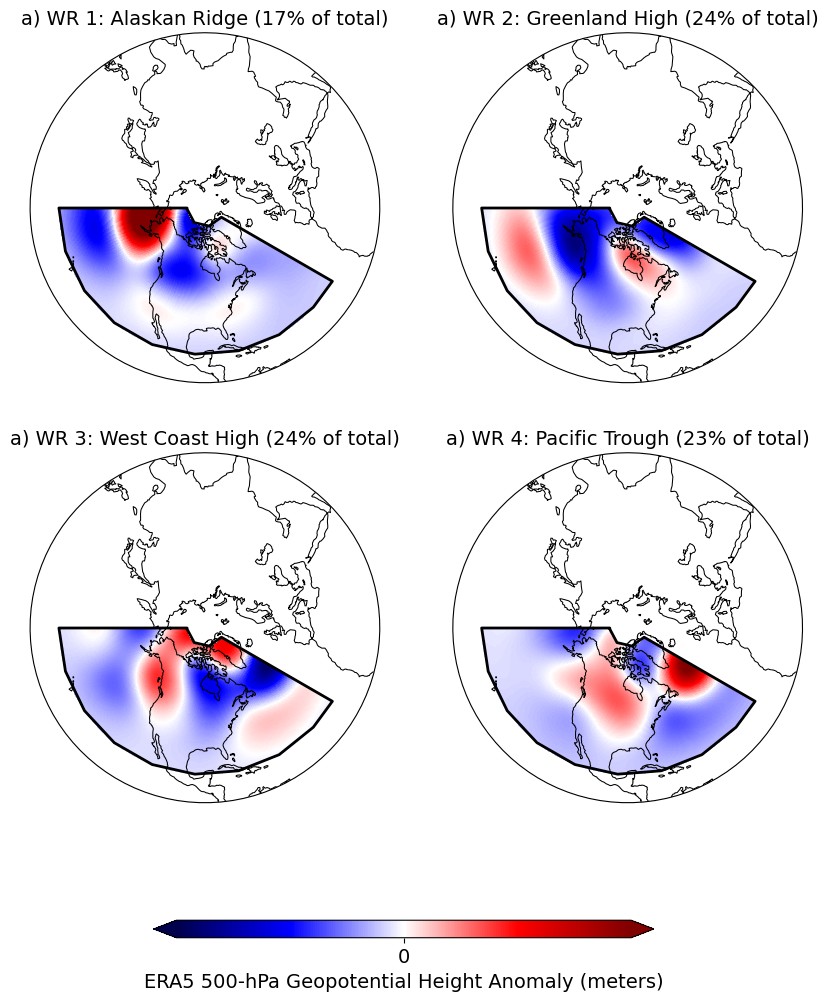

In [22]:
lons, lats = np.meshgrid(anomalies_afterPCA.lon, anomalies_afterPCA.lat)
names = ['Alaskan Ridge','Greenland High','West Coast High', 'Pacific Trough']
arrays = [mean_wr_0,mean_wr_1,mean_wr_2,mean_wr_3]
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

for iregime in range(0,4):
    if iregime == 0 :
        indax = (0,0)
    elif iregime == 1:
        indax = (0,1)
    elif iregime == 2:
        indax = (1,0)
    elif iregime == 3:
        indax = (1,1)
    
    pm = axs[indax[0]][indax[1]].pcolormesh(lons, lats, arrays[iregime],
                         transform=ccrs.PlateCarree(),
                         vmin=-1.5, vmax=1.5, cmap='seismic')

    axs[indax[0]][indax[1]].set_title(
        f'a) WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}% of total)', 
        fontsize=14)

    axs[indax[0]][indax[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[indax[0]][indax[1]].margins(x=0, y=0)

    axs[indax[0]][indax[1]].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axs[indax[0]][indax[1]].set_boundary(circle, transform=axs[indax[0]][indax[1]].transAxes)

    geom = geometry.box(minx=lon0-360, maxx=lon1-360, miny=lat0, maxy=lat1)
    # 10-70°N, 150-40°W
    axs[indax[0]][indax[1]].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                             facecolor='none', edgecolor='k', lw=2.)
    
# ---

cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

# plt.tight_layout()
# plt.savefig("../../Figures/WR_ERA5_v3.png", bbox_inches='tight', dpi=500)
plt.show()

# ---


In [23]:
mean_wr_0 = z500_anoms.Z_anomalies[where0].mean(axis=0)#/9.82
mean_wr_1 = z500_anoms.Z_anomalies[where1].mean(axis=0)#/9.82
mean_wr_2 = z500_anoms.Z_anomalies[where2].mean(axis=0)#/9.82
mean_wr_3 = z500_anoms.Z_anomalies[where3].mean(axis=0)#/9.82
mean_wr_4 = z500_anoms.Z_anomalies[where4].mean(axis=0)#/9.82

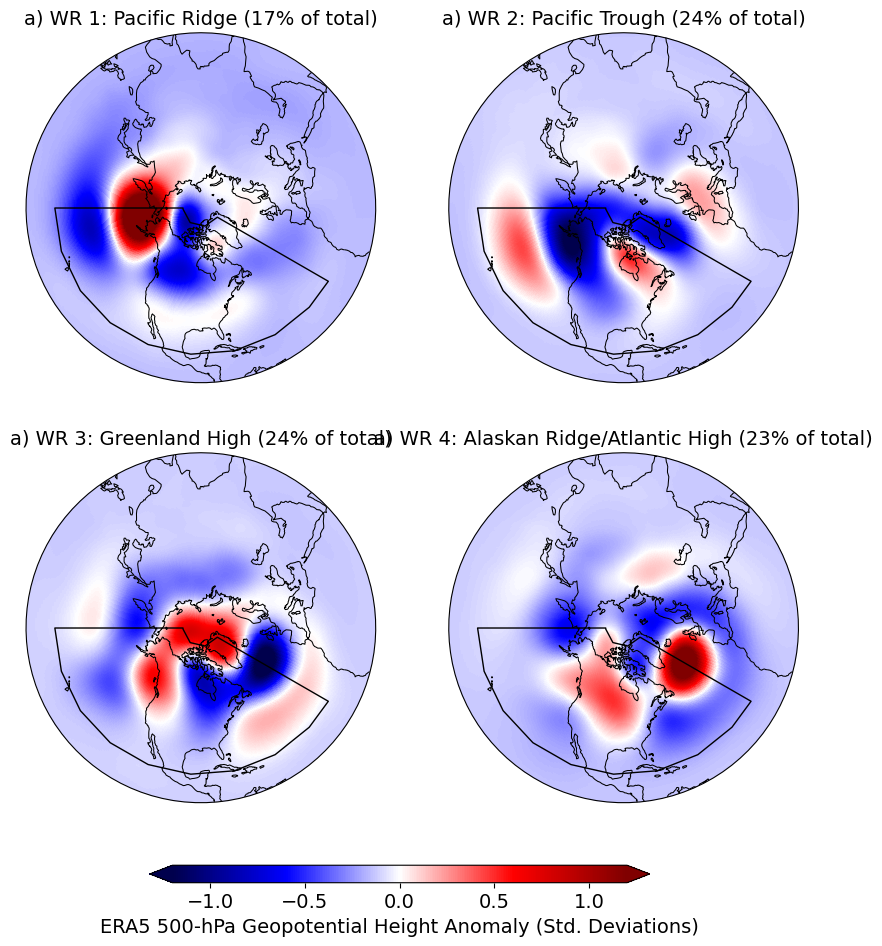

In [27]:
lons, lats = np.meshgrid(z500_anoms.lon, z500_anoms.lat)
names = ['Pacific Ridge','Pacific Trough','Greenland High','Alaskan Ridge/Atlantic High']
arrays = [mean_wr_0,mean_wr_1,mean_wr_2,mean_wr_3]
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

for iregime in range(0,4):
    if iregime == 0 :
        indax = (0,0)
    elif iregime == 1:
        indax = (0,1)
    elif iregime == 2:
        indax = (1,0)
    elif iregime == 3:
        indax = (1,1)
    
    pm = axs[indax[0]][indax[1]].pcolormesh(lons, lats, arrays[iregime],
                         transform=ccrs.PlateCarree(),
                         vmin=-1.2, vmax=1.2, cmap='seismic')

    axs[indax[0]][indax[1]].set_title(
        f'a) WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}% of total)', 
        fontsize=14)

    axs[indax[0]][indax[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[indax[0]][indax[1]].margins(x=0, y=0)

    axs[indax[0]][indax[1]].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axs[indax[0]][indax[1]].set_boundary(circle, transform=axs[indax[0]][indax[1]].transAxes)

    geom = geometry.box(minx=lon0-360, maxx=lon1-360, miny=lat0, maxy=lat1)
    # 10-70°N, 150-40°W
    axs[indax[0]][indax[1]].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                             facecolor='none', edgecolor='k', lw=1.)
    
# ---

cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.0175])

ticks_1 = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (Std. Deviations)', fontsize=14)

# ---

# plt.tight_layout()
plt.savefig("WR_ERA5_20230815_v2.png", bbox_inches='tight')
plt.show()

# ---
